In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helper Functions

1. normalize_z(df): Standardization: Write a function that takes in data frame where all the column are the features and normalize each column according to the following formula.

    $$normalized = \frac{data - \mu}{\sigma}$$

    where $\mu$ is the mean of the data and $\sigma$ is the standard deviation of the data. The function returns a new dataframe.

        Using following functions from Pandas:
        - df.mean(axis=0): To calculate the mean along the index axis.
        - df.std(axis=0): To calculate the standard deviation along the index axis.


2. get_features_targets(df, feature_names, target_names): To get the columns for the features and the targets from the input argument data frame. The function takes in Pandas' dataframe and two lists. The first list is for the feature names and the other list is for the target names.


3. prepare_feature(df_feature): Takes in a data frame for the feature. The function converts the data frame to a numpy array and changes it into a column vector. The function adds a column of constant 1s in the first column.


4. prepare_target(df_target): Takes in a data frame for the target. The function converts the data frame to a numpy array and changes it into column vectors. 


5. predict(df_feature, beta): This standardizes the feature using z normalization, changes it to a Numpy array, and adds a column of constant 1s. prepare_feature() is used for this purpose. Lastly, this function calls predict_norm() to get the predicted y values.


6. predict_norm(X, beta): Calculates the straight line equation after standardization and adds column for constant 1.


7. split_data(df_feature, df_target, random_state=None, test_size=0.5): Split the Data Frame randomly. The function has the following arguments:
    - df_feature: Data frame for the features.
    - df_target: Data frame for the target.
    - random_state: Seed used to split randomly.
    - test_size: Fraction for the test data set (0 to 1), by default is set to 0.3

    The output of the function is a tuple of four items:
    - df_feature_train: Train set for the features data frame
    - df_feature_test: Test set for the features data frame
    - df_target_train: Train set for the target data frame
    - df_target_test: Test set for the target data frame

8. r2_score(y, ypred): Calculates the coefficient of determination as given by the following equations.

    $$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$


9. mean_squared_error(target, pred): Calculate the MSE

    $$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$

10. adjusted_rsquare(rsquare, samplesize, features): r^2 is not an accurate measure. The adjusted r^2 method can provide a more precise view of the correlation by additionally taking into account the number of independent variables are added to the particular model.

In [2]:
def normalize_z(df):
    mean = df.mean()
    std = df.std(axis=0)
    return (df - mean)/std
    pass

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns)
    feature = df_feature.to_numpy().reshape(-1, cols)
    X = np.concatenate((np.ones((feature.shape[0], 1)), feature), axis=1)
    return X

def prepare_target(df_target):
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1, cols)
    return target

def predict(df_feature, beta):
    feature = prepare_feature(normalize_z(df_feature))
    predicted_y = predict_norm(feature, beta)
    return predicted_y

def predict_norm(X, beta):
    return np.matmul(X, beta)
    pass

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    ### BEGIN SOLUTION
    indexes = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k = int(test_size * len(indexes)) # 0.3 * 506 --> 151 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index # set subtraction

    df_feature_train = df_feature.loc[train_index, :] # select the rows as per train_index, and all its columns
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    ### END SOLUTION
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def r2_score(y, ypred):
    ybar = np.mean(y)
    y_minus_ypred = y - ypred
    y_minus_ybar = y - ybar 
    ss_res = np.sum(np.matmul(y_minus_ypred.T, y_minus_ypred))
    ss_tot = np.sum(np.matmul(y_minus_ybar.T, y_minus_ybar))
    
    return 1 - (ss_res/ss_tot)    

def mean_squared_error(target, pred):
    y_minus_ypred = pred - target
    y_minus_ypred_sq = np.matmul(y_minus_ypred.T, y_minus_ypred)
    summation = np.sum(y_minus_ypred_sq)
    mse = (1/len(target)) * summation
    return mse
    pass

# Data pre-processing

- Selection of 20 countries
    - We use the criteria that at least 315 rows in each country for each of our selected features contain a value.
    - We use the function `df.isna().sum()` to find the number of NaN values in each column 
- Cleaning of data
    - After selecting 20 countries based on the above criterion, we drop the NaN values using the function `df.dropna()`
- Selection of features
    - We have analysed different permuatations of features for our model, including changing the number of features and testing out a polynomial relationship.
    - From the analysis we have done using Excel and research we have conducted, we arrive upon the optimal model with the features:
        - 'new_cases_per_million' 
        - 'icu_patients_per_million'
        - 'hospital_beds_per_thousand'
        - 'human_development_index'
        - 'aged_65_older'
        - 'gdp_per_capita'
        - 'new_vaccinations_smoothed_per_million'
        - 'stringency_index'


In [25]:
df_all = pd.read_csv("Raw Data for All Countries.csv")

In [155]:
features_list = ['new_cases_per_million', 'icu_patients_per_million', 'hospital_beds_per_thousand', 'human_development_index', 'aged_65_older', 'gdp_per_capita', 'new_vaccinations_smoothed_per_million', 'stringency_index']
target_list = ['new_deaths_per_million']
country_list = df_all["iso_code"].unique()

The helper function `filter_by_country(dfin, country_code)`  filters the dataframe by the `iso_code` of the country.

In [156]:
def filter_by_country(dfin, country_code):
    dfin = dfin.copy()
    return dfin[dfin["iso_code"] == country_code]

In [157]:
df_countries = {}
for country in country_list:
    df_countries[country] = filter_by_country(df_all, country)

# creates a dictionary with the keys being the country 'iso_code' and the values being the dataframe filtered by country.

In [158]:
df_values = {}
for country in country_list:
    df_country = df_countries[country]
    df_features, df_target = get_features_targets(df_country, features_list, target_list)
    df_values[country] = df_features.isna().sum() 
    
# creates a dictionary with the keys being the country 'iso_code' and the values being
# a pandas series showing the sum of NaN values in each column

In [198]:
df_values["AUT"]

# example of the pandas series mentioned above

new_cases_per_million                      0
icu_patients_per_million                  39
hospital_beds_per_thousand                 0
human_development_index                    0
aged_65_older                              0
gdp_per_capita                             0
new_vaccinations_smoothed_per_million    307
stringency_index                           2
dtype: int64

In [159]:
dataful_countries = []
for country in country_list:
    can = True
    for i in df_values[country].items():
        if len(df_countries[country]) - i[1] < 315:
            can = False
    if can == True:
        dataful_countries.append(country)
        
# filters out the countries that have at least 315 values that are non-empty for each feature column            

In [160]:
dataful_countries

# list of countries with data that meets our criterion

['AUT',
 'BEL',
 'BGR',
 'CAN',
 'CZE',
 'DNK',
 'EST',
 'FIN',
 'FRA',
 'DEU',
 'IRL',
 'ISR',
 'ITA',
 'LUX',
 'PRT',
 'ROU',
 'SVN',
 'SWE',
 'CHE',
 'USA']

In [161]:
len(dataful_countries)

20

In [162]:
df_dataful = pd.DataFrame()
for country in dataful_countries:
    df_dataful = df_dataful.append(filter_by_country(df_all, country))
    
df_dataful_features, df_dataful_target = get_features_targets(df_dataful, features_list, target_list)

master_df = pd.merge(left=df_dataful_features.dropna(), left_index=True, right=df_dataful_target.dropna(), right_index=True, how='inner')

master_df

# we obtain a master_df with the desired countries and the selected features

,new_cases_per_million,icu_patients_per_million,hospital_beds_per_thousand,human_development_index,aged_65_older,gdp_per_capita,new_vaccinations_smoothed_per_million,stringency_index,new_deaths_per_million
7855,176.046,46.555,7.37,0.922,19.202,45436.686,146.0,82.41,5.529
7856,206.567,45.449,7.37,0.922,19.202,45436.686,166.0,82.41,14.154
7857,281.984,43.680,7.37,0.922,19.202,45436.686,162.0,82.41,9.952
7858,322.125,43.790,7.37,0.922,19.202,45436.686,122.0,82.41,8.072
7859,231.780,42.574,7.37,0.922,19.202,45436.686,97.0,82.41,4.313
...,...,...,...,...,...,...,...,...,...
127137,439.304,33.864,2.77,0.926,15.413,54225.446,3634.0,44.91,7.461
127138,122.653,33.979,2.77,0.926,15.413,54225.446,3658.0,44.91,1.358
127139,90.597,33.840,2.77,0.926,15.413,54225.446,3656.0,44.91,0.360
127140,416.884,34.648,2.77,0.926,15.413,54225.446,3424.0,44.91,3.818


<h4> Obtaining pairplots for our selected data will give us a visualised perspective on the potential relationship between our selected features and target variable. </h4>
    

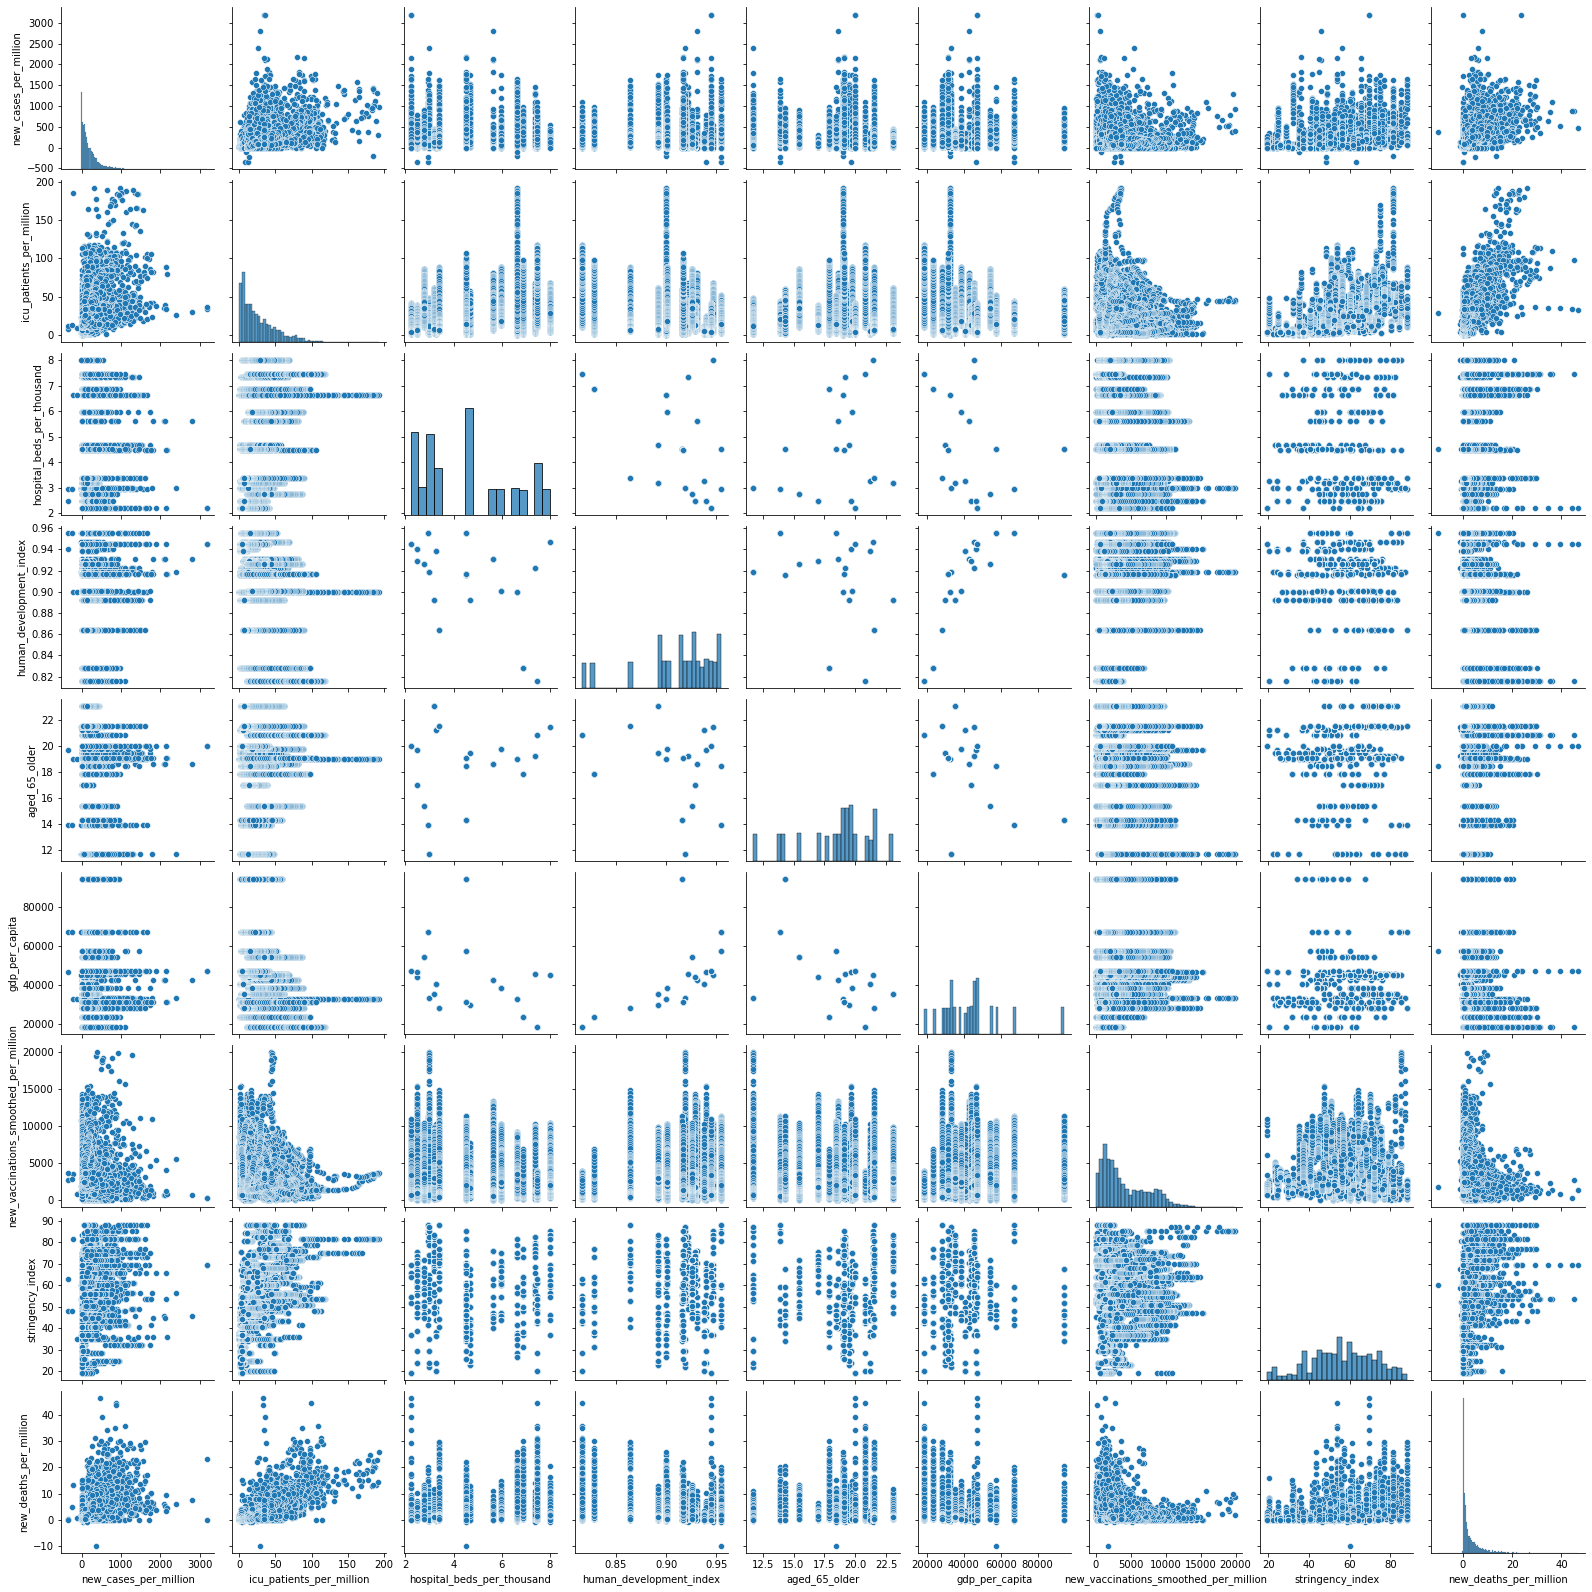

In [199]:
sns.pairplot(master_df)

# Training the model

- We prepare features and target using the `prepare_feature()` and `prepare_target()` functions.
- The `compute_cost()` function computes the error for each data point, for each iteration
- The `gradient_descent()` function minimizes this cost by updating the weights

In [164]:
df_master_features, df_master_target = get_features_targets(master_df, features_list, target_list)
df_master_features = normalize_z(df_master_features)

In [165]:
X = prepare_feature(df_master_features)
target = prepare_target(df_master_target)

In [166]:
def compute_cost(X, y, beta):
    y_hat = np.matmul(X, beta)
    error = y_hat - y
    error_sq = np.matmul(error.T, error)
    m = X.shape[0]
    J = (1/(2*m)) * error_sq
    J = J[0][0]
    ###
    ### YOUR CODE HERE
    ###
    return J

In [167]:
def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = np.zeros((num_iters, 1))
    for n in range(num_iters):
        deriv = np.matmul(X.T, (np.matmul(X, beta) - y))
        beta = beta - alpha * (1/m) * deriv
        J_storage[n] = compute_cost(X, y, beta)
    
    
    return beta, J_storage

In [171]:
# Extract the features and the target
df_master_features, df_master_target = get_features_targets(master_df, features_list, target_list)

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_master_features, df_master_target)

# Normalize the features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((len(features_list) + 1, 1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict(df_features_test, beta)

We plot `J_storage` to visualize the minimization of the cost

[[ 2.88068215]
 [ 1.12149337]
 [ 2.20116558]
 [-0.2857093 ]
 [-0.83180506]
 [ 0.2825699 ]
 [ 0.24247393]
 [-0.50232241]
 [ 0.31034106]]


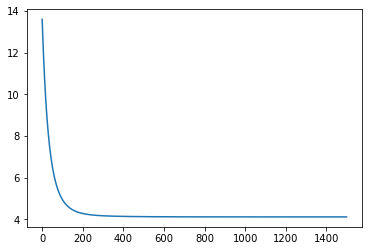

In [183]:
print(beta)
plt.plot(J_storage)

We then plot each feature against the predicted value and superimpose that on the plot of the feature against the target value.

This shows us how closely our model is able to predict based on the test data

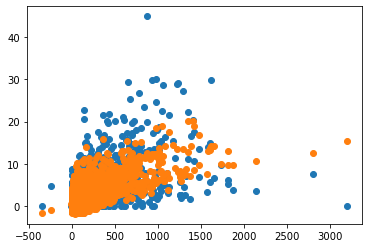

In [184]:
plt.scatter(df_features_test[features_list[0]], df_target_test)
plt.scatter(df_features_test[features_list[0]], pred)

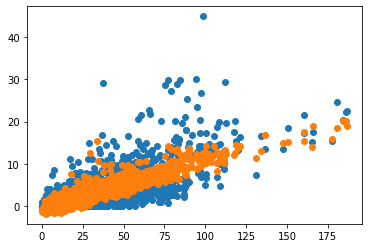

In [185]:
plt.scatter(df_features_test[features_list[1]], df_target_test)
plt.scatter(df_features_test[features_list[1]], pred)

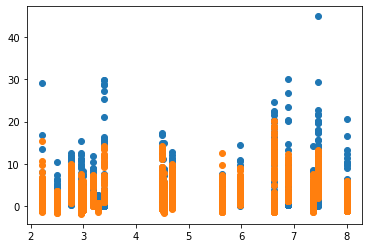

In [186]:
plt.scatter(df_features_test[features_list[2]], df_target_test)
plt.scatter(df_features_test[features_list[2]], pred)

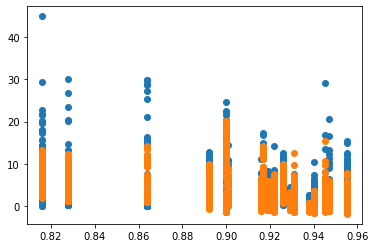

In [187]:
plt.scatter(df_features_test[features_list[3]], df_target_test)
plt.scatter(df_features_test[features_list[3]], pred)

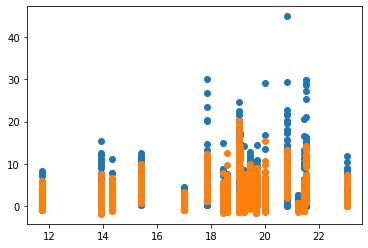

In [188]:
plt.scatter(df_features_test[features_list[4]], df_target_test)
plt.scatter(df_features_test[features_list[4]], pred)

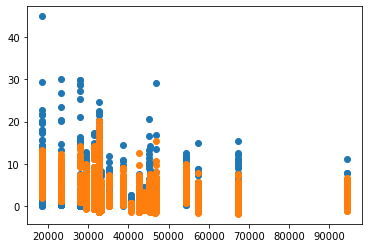

In [189]:
plt.scatter(df_features_test[features_list[5]], df_target_test)
plt.scatter(df_features_test[features_list[5]], pred)

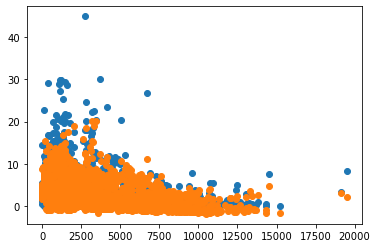

In [190]:
plt.scatter(df_features_test[features_list[6]], df_target_test)
plt.scatter(df_features_test[features_list[6]], pred)

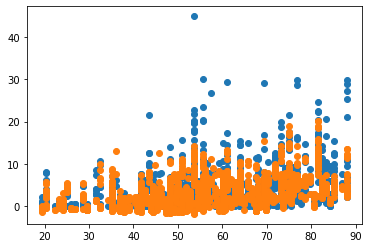

In [191]:
plt.scatter(df_features_test[features_list[7]], df_target_test)
plt.scatter(df_features_test[features_list[7]], pred)

In [193]:
target = df_target_test.to_numpy()

# Calculate r2 score by calling the r2_score() function
r2 = r2_score(target, pred)

print(r2)

0.6137185056316705


In [194]:
# Adjusted R-squared can provide a more precise view of the correlation by taking into account how many 
# independent variables (features) are added to the model against which the the target values are measured.

def adjusted_rsquare(rsquare, samplesize, features):
    result = 1 - ((1-rsquare)*(samplesize-1)/(samplesize-features-1))
    return result

adj_r_square = adjusted_rsquare(r2, len(target), len(features_list))

print(adj_r_square)

0.6120920572343302


In [195]:
mse = mean_squared_error(target, pred)

print(mse)

7.601756627277043


In [37]:
master_df.to_excel("master_data.xlsx")